# Taller de Análisis de Texto con Tweets en Español

Este taller guía a los estudiantes en el análisis de tweets en español, usando técnicas de limpieza de texto, análisis de frecuencia de palabras y análisis de sentimientos. También incluye preguntas orientadas al negocio.

In [1]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-11-06 00:04:54--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-11-06 00:04:54--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv’

Gender_bias_s

## 1. Configuración e Importación de Librerías
Primero, importaremos las librerías necesarias y cargaremos el conjunto de datos.

In [25]:
!pip install nltk textblob wordcloud
import pandas as pd
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cargar el Conjunto de Datos
Cargamos el archivo CSV que contiene los tweets y las etiquetas ('biased' o 'non-biased').

In [3]:
data = pd.read_csv('Gender_bias_spanish.csv')

In [4]:
data

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased
...,...,...
1909,"iba a ir a dash pero mis 3 cortadas, mi color ...",non-biased
1910,que pinche chiste tiene estar medio alto si to...,non-biased
1911,si fuera bien idiota. ya hubiera comprado un a...,non-biased
1912,nota mental: no le quieras ayudar a alguien qu...,non-biased


## 2. Exploración de Datos
Exploraremos el conjunto de datos para entender mejor la distribución de etiquetas y las características de los tweets.

In [8]:
# Resumen del conjunto de datos
data.head()

,Contents,Label
0,@chumeltorres ya cabrón! sin tí se reciben las...,biased
1,¿alguien es tan amable de ir a hacerme la comp...,non-biased
2,"@jenniferduquee hahaha, si está rico, nadamas ...",non-biased
3,@evagelcot donde lo ves!!? es mi programa favo...,non-biased
4,como siempre mi tortilla triunfa mas que otros...,non-biased


In [9]:
# Contar la cantidad de tweets por etiqueta
data["Label"].value_counts(normalize=True)

,proportion
Label,
non-biased,0.833856
biased,0.166144


**Pregunta:** ¿Qué proporción de tweets son 'biased' y 'non-biased'? ¿Por qué podría ser importante esta proporción para el análisis de texto?

La mayoría de los tweets son non-biased, mientras que una menor proporción son biased.Esta diferencia es importante porque si los datos están desbalanceados, los modelos de análisis de texto podrían aprender mejor a reconocer los tweets sin sesgo y tener más dificultad para identificar los que sí lo tienen.

## 3. Preprocesamiento de Texto
Realizamos una serie de pasos para limpiar y preparar el texto para el análisis: limpieza de caracteres especiales, conversión a minúsculas, y eliminación de stopwords.

In [19]:
# Cree una funcion limpiar texto
def limpiar_texto(texto):
    texto = str(texto).lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'@\w+', '', texto)
    texto = re.sub(r'#', '', texto)
    texto = re.sub(r'\d+', '', texto)
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [26]:
# Aplicar la limpieza de texto
data['Contents_limpio'] = data['Contents'].apply(limpiar_texto)

In [27]:
data[['Contents', 'Contents_limpio']].head()

,Contents,Contents_limpio
0,@chumeltorres ya cabrón! sin tí se reciben las...,ya cabrón sin tí se reciben las noticias sin c...
1,¿alguien es tan amable de ir a hacerme la comp...,¿alguien es tan amable de ir a hacerme la comp...
2,"@jenniferduquee hahaha, si está rico, nadamas ...",hahaha si está rico nadamas le falta presentación
3,@evagelcot donde lo ves!!? es mi programa favo...,donde lo ves es mi programa favorito y sólo en...
4,como siempre mi tortilla triunfa mas que otros...,como siempre mi tortilla triunfa mas que otros...


## 4. Análisis de Frecuencia de Palabras por Etiqueta
Contamos las palabras en tweets 'biased' y 'non-biased' y visualizamos las palabras más comunes.

In [41]:
# Separar los tweets por etiqueta
biased_texts = data[data['Label'] == 'biased']['Contents_limpio']
non_biased_texts = data[data['Label'] == 'non-biased']['Contents_limpio']

# Unir todos los textos en una sola cadena por grupo
biased_words = ' '.join(biased_texts).split()
non_biased_words = ' '.join(non_biased_texts).split()

# Contar frecuencia de palabras
biased_freq = Counter(biased_words)
non_biased_freq = Counter(non_biased_words)

In [40]:
# Visualización de frecuencia de palabras

In [42]:
print("Palabras más comunes en tweets 'biased':")
print(biased_freq.most_common(10))

Palabras más comunes en tweets 'biased':
[('que', 172), ('no', 137), ('de', 136), ('a', 121), ('y', 116), ('la', 95), ('me', 90), ('es', 76), ('en', 68), ('las', 56)]


In [43]:
print("\nPalabras más comunes en tweets 'non-biased':")
print(non_biased_freq.most_common(10))


Palabras más comunes en tweets 'non-biased':
[('de', 946), ('que', 916), ('y', 710), ('no', 595), ('a', 559), ('la', 556), ('me', 467), ('el', 442), ('en', 438), ('es', 368)]


In [47]:
import matplotlib.pyplot as plt
biased_df = pd.DataFrame(biased_freq.most_common(10), columns=['Palabra', 'Frecuencia'])
non_biased_df = pd.DataFrame(non_biased_freq.most_common(10), columns=['Palabra', 'Frecuencia'])

Text(0, 0.5, 'Frecuencia')

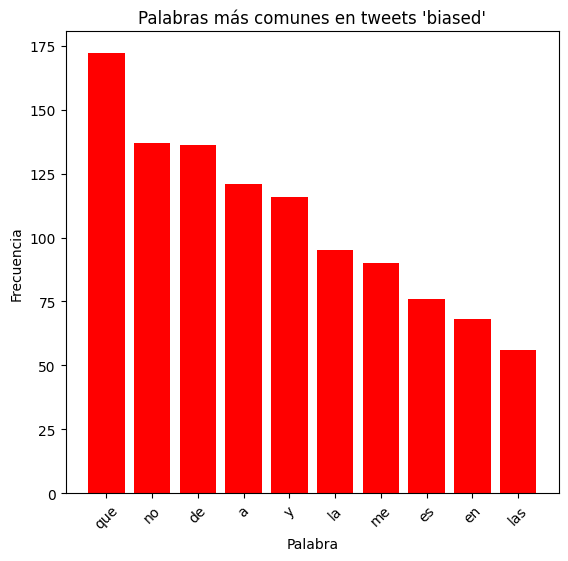

In [48]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.bar(biased_df['Palabra'], biased_df['Frecuencia'], color='red')
plt.title("Palabras más comunes en tweets 'biased'")
plt.xticks(rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

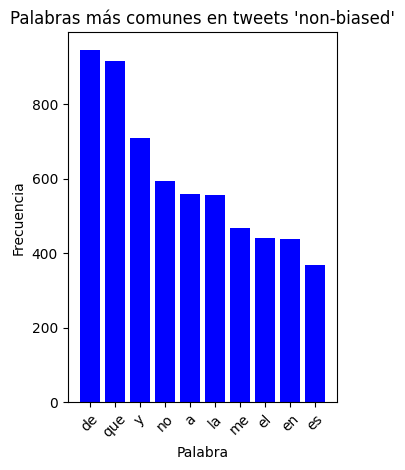

In [49]:
plt.subplot(1, 2, 2)
plt.bar(non_biased_df['Palabra'], non_biased_df['Frecuencia'], color='blue')
plt.title("Palabras más comunes en tweets 'non-biased'")
plt.xticks(rotation=45)
plt.xlabel('Palabra')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Preguntas de Análisis de Frecuencia:**

**- ¿Qué palabras son más comunes en los tweets 'biased' en comparación con los 'non-biased'?**

En los tweets etiquetados como biased suelen aparecer con más frecuencia palabras que reflejan opiniones, emociones, juicios de valor, nombres de figuras políticas o marcas mencionadas de forma negativa o positiva. En cambio, los tweets non-biased presentan términos más neutrales, descriptivos o informativos, centrados en hechos concretos sin adjetivos cargados de emoción.

**- ¿Hay palabras que sugieran un sesgo en los tweets etiquetados como 'biased'?**

Sí. Las palabras que expresan emoción, exageración o juicio pueden indicar un sesgo. También los pronombres personales o apelaciones directas, reflejan una intención de persuadir o señalar culpables, lo cual muestra parcialidad.


**- ¿Cómo podrían usar las empresas esta información para entender mejor las opiniones sesgadas?**

Las empresas pueden usar este análisis para identificar patrones de lenguaje en comentarios o publicaciones con sesgo. Así, pueden detectar rápidamente cuándo una conversación pública se está volviendo emocional o polarizada respecto a su marca, producto o sector. También podrían adaptar su comunicación para responder con mensajes más empáticos o basados en datos, evitando escalar conflictos y mejorando su reputación digital.

## 6. Visualización con Nube de Palabras
Usamos una nube de palabras para visualizar las palabras más comunes en cada conjunto de tweets.

In [70]:
# Cree una funcion para geenrar nube de palabras
def generar_nube_palabras(texto):
    palabras = (limpiar_texto(texto))
    nube = WordCloud(width=800, height=400, background_color='white').generate(palabras)
    plt.figure(figsize=(10, 5))
    plt.imshow(nube, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [81]:
# Generar nube de palabras para cada conjunto

In [82]:
# NO biased nube de palabras

In [83]:
non_biased=data[data['Label'] == 'non-biased']

In [84]:
texto=' '.join(non_biased['Contents'])

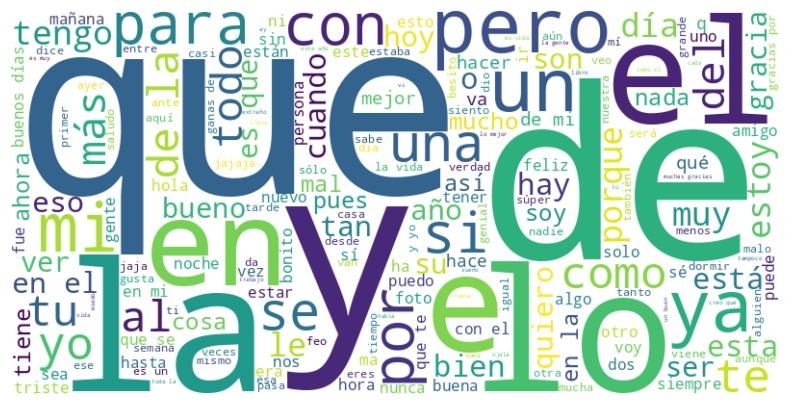

In [85]:
generar_nube_palabras(texto)

In [86]:
# biased nube de palabras

In [87]:
biased=data[data['Label'] == 'biased']

In [88]:
texto=' '.join(biased['Contents'])

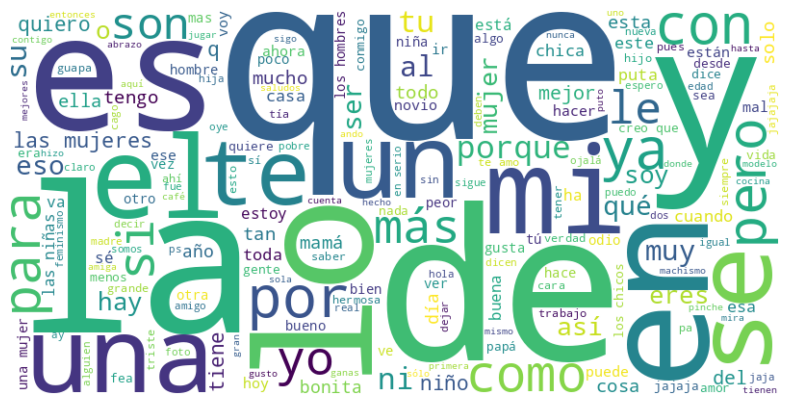

In [89]:
generar_nube_palabras(texto)

## 7. Conclusiones y Perspectiva de Negocios
En este taller, hemos explorado cómo el análisis de texto puede ofrecer información valiosa sobre el contenido y el sentimiento de los tweets. Reflexionemos sobre algunas preguntas de negocio:

**- ¿Cómo podría utilizarse este análisis para mejorar la comunicación de la marca?**

Este análisis permite entender cómo el público percibe y habla sobre la marca en redes sociales. Si se identifican palabras frecuentes asociadas con opiniones sesgadas, la marca puede ajustar su tono comunicativo para ser más neutral, empático y transparente. Además, ayuda a anticipar posibles crisis de reputación y a reforzar mensajes que conecten mejor con las emociones y preocupaciones reales de los usuarios.

**- ¿Qué ajustes se podrían hacer en una campaña de marketing si los tweets son predominantemente 'biased'?**

Si la mayoría de los tweets son biased, significa que las conversaciones están influenciadas por emociones o juicios fuertes. En ese caso, la marca podría enfocarse en estrategias de comunicación más equilibradas, ofreciendo datos verificables, testimonios reales o mensajes que desactiven la polarización. También podría replantear el enfoque creativo de la campaña para conectar desde la empatía en lugar de la confrontación, mostrando apertura al diálogo con los consumidores.

**- ¿Qué patrones importantes se podrían explorar en un análisis futuro (e.g., análisis de tendencias a lo largo del tiempo)?**

En futuros análisis se podrían estudiar los cambios en el lenguaje y la frecuencia de palabras a lo largo del tiempo, para detectar si las opiniones hacia la marca se vuelven más positivas, negativas o neutrales. También sería útil analizar los temas o eventos que generan picos de sesgo, así como comparar el tipo de vocabulario usado por diferentes grupos como por edad, región o género para diseñar estrategias de comunicación más segmentadas y efectivas.